<a href="https://colab.research.google.com/github/Kuliah-Machine-Learning/2021-Batik-Kel-11/blob/main/Klasifikasi_Motif_Kain_Batik_Kel_11__VGG_16Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/Kuliah-Machine-Learning/2021-Batik-Kel-11.git

Cloning into '2021-Batik-Kel-11'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 109 (delta 1), reused 109 (delta 1), pack-reused 0
Receiving objects: 100% (109/109), 2.39 MiB | 37.59 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
%cd 2021-Batik-Kel-11

/content/2021-Batik-Kel-2/2021-Batik-Kel-11


In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [9]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls Database/
!ls Database/Train/Keraton
!ls Database/Train/Pekalongan

Test  Train
11.jpg	15.jpg	19.jpg	23.jpg	27.jpg	31.jpg	35.jpg	39.jpg	43.jpg	47.jpg
12.jpg	16.jpg	20.jpg	24.jpg	28.jpg	32.jpg	36.jpg	40.jpg	44.jpg	48.jpg
13.jpg	17.jpg	21.jpg	25.jpg	29.jpg	33.jpg	37.jpg	41.jpg	45.jpg	49.jpg
14.jpg	18.jpg	22.jpg	26.jpg	30.jpg	34.jpg	38.jpg	42.jpg	46.jpg	50.jpg
pekalongan_11.jpg  pekalongan_21.jpg  pekalongan_31.jpg  pekalongan_41.jpg
pekalongan_12.jpg  pekalongan_22.jpg  pekalongan_32.jpg  pekalongan_42.jpg
pekalongan_13.jpg  pekalongan_23.jpg  pekalongan_33.jpg  pekalongan_43.jpg
pekalongan_14.jpg  pekalongan_24.jpg  pekalongan_34.jpg  pekalongan_44.jpg
pekalongan_15.jpg  pekalongan_25.jpg  pekalongan_35.jpg  pekalongan_45.jpg
pekalongan_16.jpg  pekalongan_26.jpg  pekalongan_36.jpg  pekalongan_46.jpg
pekalongan_17.jpg  pekalongan_27.jpg  pekalongan_37.jpg  pekalongan_47.jpg
pekalongan_18.jpg  pekalongan_28.jpg  pekalongan_38.jpg  pekalongan_48.jpg
pekalongan_19.jpg  pekalongan_29.jpg  pekalongan_39.jpg  pekalongan_49.jpg
pekalongan_20.jpg  pekalongan_30.

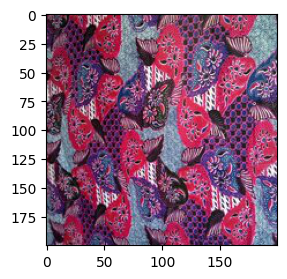

In [10]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("Database/Train/Pekalongan/pekalongan_11.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [23]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 200
BATCH_SIZE = 45
base_dir = os.path.join('Database/Train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Keraton', 'Pekalongan']

for i,label in enumerate(labels):
    folder = os.path.join("Database/Test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(200,200))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 72 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Bentuk array dari dataset train (pelatihan) adalah: (45, 200, 200, 3) (45, 2)
Bentuk array dari dataset validation (validasi) adalah: (8, 200, 200, 3) (8, 2)
Bentuk array dari dataset test (pengujian) adalah: (20, 200, 200, 3) (20,)


In [24]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Keraton': 0, 'Pekalongan': 1}


In [25]:
!cat labels.txt

Keraton
Pekalongan

In [26]:
IMG_SHAPE = (200, 200, 3)
#Membuat dasar(base model) dari pre-trained model VGG16:
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [27]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [28]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [30]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [33]:
model = tf.keras.Sequential([
   base_model,
   tf.keras.layers.Conv2D(32, 4, activation='relu'),
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(2, activation='softmax')                          
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          262176    
                                                                 
 global_average_pooling2d_2   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 14,976,930
Trainable params: 262,242
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
history = model.fit_generator(train_generator,
                              epochs=50,
                              validation_data=val_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
2/2 [==============================] - 29s 19s/step - loss: 1.0958 - acc: 0.5139 - val_loss: 0.8735 - val_acc: 0.5000
Epoch 2/50
2/2 [==============================] - 28s 12s/step - loss: 0.8105 - acc: 0.4583 - val_loss: 0.7678 - val_acc: 0.5000
Epoch 3/50
2/2 [==============================] - 28s 12s/step - loss: 0.6913 - acc: 0.5833 - val_loss: 0.6871 - val_acc: 0.5000
Epoch 4/50
2/2 [==============================] - 28s 12s/step - loss: 0.5291 - acc: 0.7222 - val_loss: 0.5857 - val_acc: 0.7500
Epoch 5/50
2/2 [==============================] - 30s 14s/step - loss: 0.4985 - acc: 0.7639 - val_loss: 0.5948 - val_acc: 0.7500
Epoch 6/50
2/2 [==============================] - 28s 19s/step - loss: 0.4604 - acc: 0.7083 - val_loss: 0.5263 - val_acc: 0.6250
Epoch 7/50
2/2 [==============================] - 28s 12s/step - loss: 0.3652 - acc: 0.9167 - val_loss: 0.5891 - val_acc: 0.6250
Epoch 8/50
2/2 [==============================] - 28s 12s/step - loss: 0.3722 - acc: 0.8611 - val

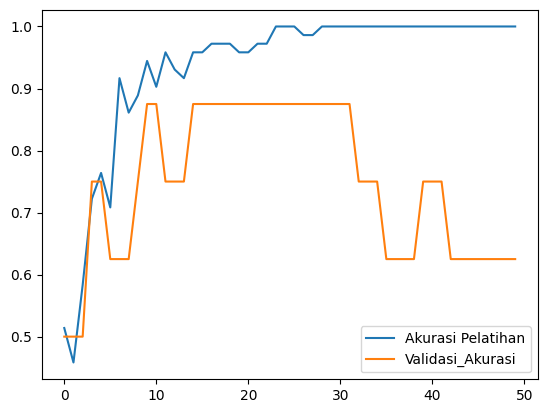

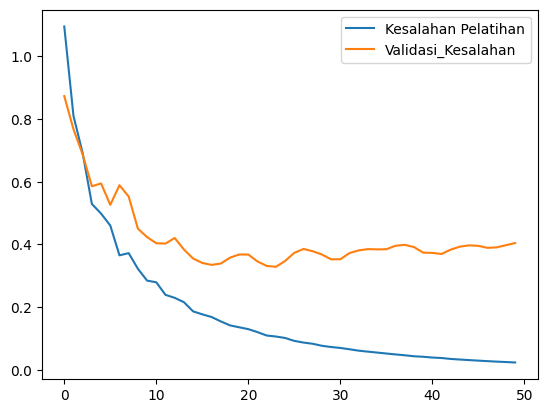

In [35]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi_Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi_Kesalahan")
plt.legend()
plt.show()

In [36]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [37]:
print(train_generator)

In [78]:
#Prediksi Label Validasi dengan Pelatihan
n = 7
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0.]
Prediksinya adalah [0.4329672  0.56703275]


In [79]:
print(model.metrics_names)
print(model.evaluate(train_generator))
print(model.evaluate(val_generator))
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
2/2 [==============================] - 27s 10s/step - loss: 0.0221 - acc: 1.0000
[0.022103063762187958, 1.0]
1/1 [==============================] - 3s 3s/step - loss: 0.4045 - acc: 0.6250
[0.4044533967971802, 0.625]
1/1 [==============================] - 7s 7s/step - loss: 0.6288 - acc: 0.7500
[0.628787636756897, 0.75]


In [80]:
y_true = np.argmax(y_test2,axis=1)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1]


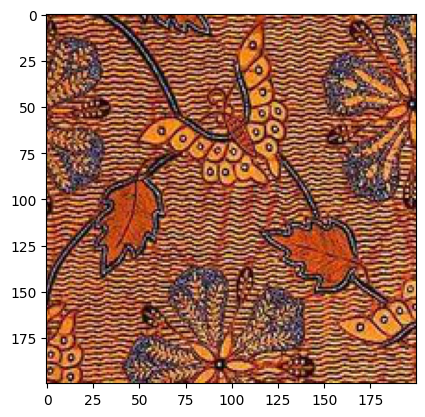

Label yang Benar: 0 : Keraton
Nilai yang diprediksi : [0.01045422 0.98954576]
Label yang diprediksi : 1 : Pekalongan
Prediksi Salah


In [81]:
n = 7

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang Benar:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi :",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi :",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
  print("Prediksi Benar")
else:
  print("Prediksi Salah")

Normalized confusion matrix
[[0.6 0.4]
 [0.1 0.9]]


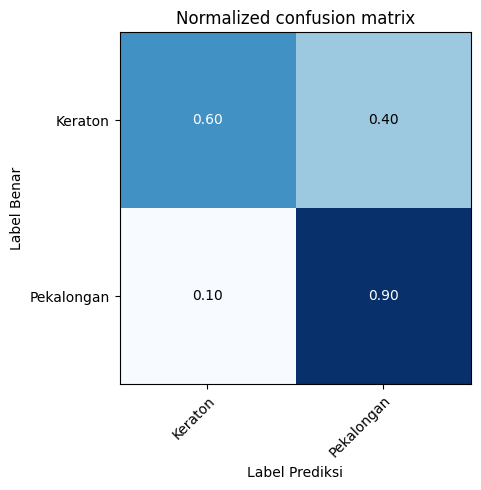

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [84]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi Motif Kain Batik_Kel_11__VGG_16Net.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets


INFO:tensorflow:Assets written to: save/model/assets
